In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sklearn.model_selection as train_test_split
from torch.utils.data import dataset, DataLoader
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
N_train = 3000
N_test  = 900

X_train = X_train[:N_train]
y_train = y_train[:N_train]
X_test  = X_test[:N_test]
y_test  = y_test[:N_test]

X_train.shape

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


(3000, 32, 32, 3)

In [ ]:
_, counts_train = np.unique(y_train, return_counts=True)
_, counts_test  = np.unique(y_test,  return_counts=True)

print("Train counts per class:", counts_train)
print("Test counts per class: ", counts_test)


Train counts per class: [299 287 322 285 311 279 312 297 308 300]
Test counts per class:  [ 92  76  92  93  83  80 100  95  92  97]


In [ ]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
X_test.shape

(900, 32, 32, 3)

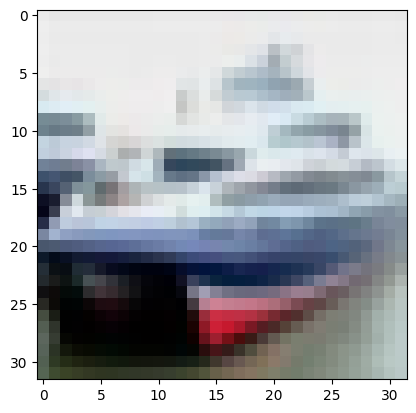

In [ ]:
plt.imshow(X_test[1])

In [ ]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0


X_test[10]

array([[[0.3529412 , 0.4862745 , 0.58431375],
        [0.3529412 , 0.4862745 , 0.58431375],
        [0.35686275, 0.49019608, 0.5882353 ],
        ...,
        [0.40392157, 0.5137255 , 0.5803922 ],
        [0.39215687, 0.5019608 , 0.57254905],
        [0.39215687, 0.5058824 , 0.57254905]],

       [[0.36078432, 0.49803922, 0.6       ],
        [0.3647059 , 0.49803922, 0.59607846],
        [0.36862746, 0.5019608 , 0.6       ],
        ...,
        [0.44705883, 0.5372549 , 0.5921569 ],
        [0.40392157, 0.50980395, 0.5803922 ],
        [0.4       , 0.5176471 , 0.59607846]],

       [[0.3647059 , 0.5019608 , 0.6       ],
        [0.3647059 , 0.49803922, 0.59607846],
        [0.36862746, 0.5019608 , 0.59607846],
        ...,
        [0.44705883, 0.52156866, 0.5686275 ],
        [0.40392157, 0.5058824 , 0.5764706 ],
        [0.39607844, 0.5176471 , 0.59607846]],

       ...,

       [[0.39607844, 0.52156866, 0.6039216 ],
        [0.39607844, 0.5176471 , 0.6       ],
        [0.4       , 0

In [ ]:
class My_Dataset(dataset.Dataset):
    def __init__(self,x,y):
      self.X = torch.tensor(x, dtype=torch.float32)
      self.Y = torch.tensor(y, dtype=torch.float32)

    def __getitem__(self,idx):
      return self.X[idx], self.Y[idx]

    def __len__(self):
      return len(self.X)

In [ ]:
training_Dataset = My_Dataset(X_train, y_train)
testing_Dataset = My_Dataset(X_test, y_test)

training_dataloader = DataLoader(training_Dataset, batch_size=64, shuffle=True)
testing_dataloader = DataLoader(testing_Dataset, batch_size =64, shuffle = True)

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class VGG16_10cls(nn.Module):
    def __init__(self, num_classes=10, freeze_backbone=True):
        super().__init__()

        vgg = models.vgg16(pretrained=True)

        if freeze_backbone:
            for param in vgg.features.parameters():
                param.requires_grad = False


        vgg.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )
        self.model = vgg

    def forward(self, x):
        return self.model(x)


In [ ]:
X_train.shape

(3000, 32, 32, 3)

In [ ]:
input_dim = X_train.shape
model = VGG16_10cls(num_classes=10, freeze_backbone=True)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters())


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 137MB/s]


In [ ]:
training_loss_per_epoch = []
testing_loss_per_epoch = []
training_acc_per_epoch = []
testing_acc_per_epoch = []


for epoch in range(35):
    total_cost    = 0.0
    total_correct = 0


    for batch_x, batch_y in training_dataloader:

        model.train()

        optimizer.zero_grad()


        batch_x = batch_x.permute(0, 3, 1, 2)
        batch_y = batch_y.long()
        batch_y = batch_y.squeeze(1)


        logits = model(batch_x)
        loss   = criterion(logits, batch_y)

        loss.backward()
        optimizer.step()


        total_cost    += loss.item()
        preds          = torch.argmax(logits, dim=1)
        total_correct += (preds == batch_y).sum().item()

    avg_cost = total_cost / len(training_dataloader)
    acc      = total_correct / len(training_dataloader.dataset)

    training_loss_per_epoch.append(avg_cost)
    training_acc_per_epoch.append(acc)
    print(f"Epoch {epoch+1:2d}: loss={avg_cost:.4f}, acc={acc:.4%}")
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    test_loss = 0.0
    total_testing_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in testing_dataloader:
              batch_x = batch_x.permute(0, 3, 1, 2)
              batch_y = batch_y.long()
              batch_y = batch_y.squeeze(1)
              logits = model(batch_x)
              test_preds  = torch.argmax(logits, dim=1)
              test_loss   = criterion(logits, batch_y)
              correct += (test_preds == batch_y).sum().item()
              all_preds.extend(test_preds.cpu().numpy())
              all_labels.extend(batch_y.cpu().numpy())
              total_testing_loss    += test_loss.item()

        avg_loss = total_testing_loss  / len(training_dataloader)
        val_accuracy = correct / len(testing_dataloader.dataset)
        testing_acc_per_epoch.append(val_accuracy)
        testing_loss_per_epoch.append(avg_loss)
        print(f"Test loss={avg_loss:.4f}, Test acc= {val_accuracy:.4%}")



Epoch  1: loss=88.9885, acc=27.1333%
Test loss=0.6431, Test acc= 37.4444%
Epoch  2: loss=1.9590, acc=42.4333%
Test loss=0.5742, Test acc= 43.4444%
Epoch  3: loss=1.5838, acc=49.5333%
Test loss=0.5203, Test acc= 47.1111%
Epoch  4: loss=1.4078, acc=54.0333%
Test loss=0.5330, Test acc= 46.1111%
Epoch  5: loss=1.2421, acc=57.6000%
Test loss=0.5179, Test acc= 49.0000%
Epoch  6: loss=1.1434, acc=60.8333%
Test loss=0.5049, Test acc= 49.4444%
Epoch  7: loss=1.0413, acc=63.8667%
Test loss=0.5318, Test acc= 50.4444%
Epoch  8: loss=0.9490, acc=67.6000%
Test loss=0.5036, Test acc= 50.8889%
Epoch  9: loss=0.8955, acc=70.1667%
Test loss=0.5133, Test acc= 50.4444%
Epoch 10: loss=0.8514, acc=69.6667%
Test loss=0.5226, Test acc= 51.5556%
Epoch 11: loss=0.7677, acc=74.0667%
Test loss=0.5552, Test acc= 52.2222%
Epoch 12: loss=0.7255, acc=74.1000%
Test loss=0.5376, Test acc= 53.5556%
Epoch 13: loss=0.6507, acc=77.4000%
Test loss=0.5627, Test acc= 52.4444%
Epoch 14: loss=0.6195, acc=78.3000%
Test loss=0.54

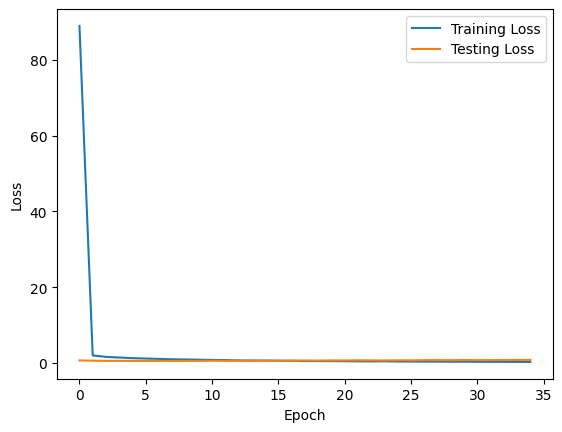

In [ ]:
plt.plot(training_loss_per_epoch, label='Training Loss')
plt.plot(testing_loss_per_epoch, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

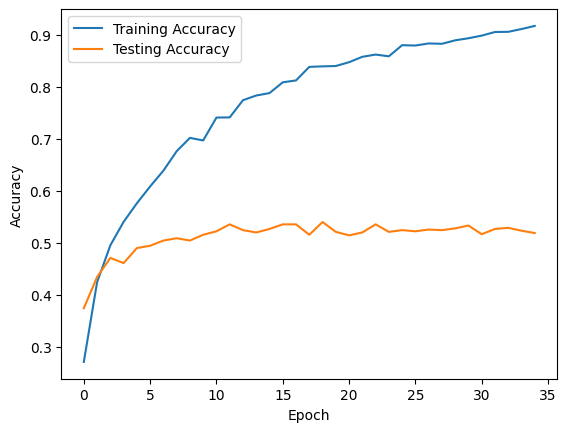

In [ ]:
plt.plot(training_acc_per_epoch, label='Training Accuracy')
plt.plot(testing_acc_per_epoch , label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print(f"Num labels:      {len(all_labels)}")
print(f"Num predictions: {len(all_preds)}")


Num labels:      900
Num predictions: 900


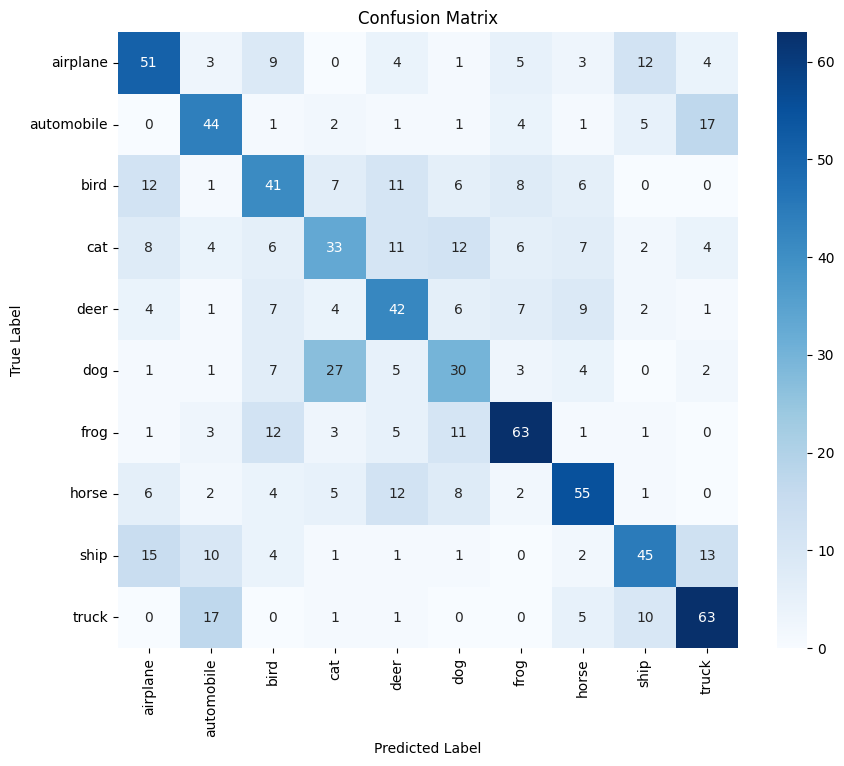

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

# Plot using seaborn
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()